**Importiere die notwendigen Packages**

In [1]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import folium 



Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [2]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

Importiere einen Datensatz von der **DWH_INT** Dropzone.

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**: https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_bestand_jahr_bevoelkerungsdichten_flaechen_od5802

(int_dwh)

In [4]:
# Filepath
fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/INT_DWH/bev_bestand_jahr_bevoelkerungsdichten_flaechen_OD5802/BEV580OD5802.csv"

# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
   #usecols=[0,1,2,3,4,6],
   #names=['stationid','year','month','avgtemp','latitude','longitude','elevation','station','countryid','country'],
   #skiprows=1,
   # parse_dates=[0],
    parse_dates=True,
    #date_parser=lambda x: pd.to_datetime(x, format="%Y"), 
    #index_col="date_time",
    low_memory=False    
    )

In der Folge ein paar erste Tests:

In [5]:
type(data2betested)

pandas.core.frame.DataFrame

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [6]:
data2betested.head(3)

,RaumKategorie,RaumSort,RaumLang,StichtagDatJahr,AnzBestWir,FlaecheT,FlaecheL,FlaecheS,DichteT,DichteL,DichteS
0,Gesamte Stadt,0,Ganze Stadt,2009,382906,9188,6526,3760,42,59,102
1,Gesamte Stadt,0,Ganze Stadt,2010,385468,9188,6522,3756,42,59,103
2,Gesamte Stadt,0,Ganze Stadt,2011,390082,9188,6522,3760,42,60,104


In [7]:
data2betested.dtypes

RaumKategorie       object
RaumSort             int64
RaumLang            object
StichtagDatJahr      int64
AnzBestWir           int64
FlaecheT           float64
FlaecheL           float64
FlaecheS           float64
DichteT            float64
DichteL            float64
DichteS            float64
dtype: object

In [8]:
data2betested.shape

(564, 11)

Beschreibe einzelne Attribute

In [9]:
data2betested.describe()

,RaumSort,StichtagDatJahr,AnzBestWir,FlaecheT,FlaecheL,FlaecheS,DichteT,DichteL,DichteS
count,564,564,564,564,564,564,564,564,564
mean,63,2014,26078,586,416,242,54,68,114
std,36,3,58357,1317,932,540,32,30,47
min,0,2009,634,26,26,13,11,14,23
25%,31,2012,7284,166,127,80,31,45,84
50%,63,2014,12944,268,188,128,43,64,107
75%,92,2017,25809,574,421,220,77,85,133
max,123,2020,434736,9189,6526,3812,152,162,250


Wie viele Nullwerte gibt es im Datensatz?

In [10]:
data2betested.isnull().sum()

RaumKategorie      0
RaumSort           0
RaumLang           0
StichtagDatJahr    0
AnzBestWir         0
FlaecheT           0
FlaecheL           0
FlaecheS           0
DichteT            0
DichteL            0
DichteS            0
dtype: int64

Wandle die Spalte Jahr von Int zu **Datetime** um. Dies wird in den meisten Grafiken so benötigt.

In [11]:
data2betested['StichtagDatJahr']=pd.to_datetime(data2betested['StichtagDatJahr'], format='%Y')

#TO DO --> setze das Datum auf den 31.12. der Jahres.
#test=data2betested[['StichtagDatJahr']].date().replace(month=12, day=31)

data2betested

,RaumKategorie,RaumSort,RaumLang,StichtagDatJahr,AnzBestWir,FlaecheT,FlaecheL,FlaecheS,DichteT,DichteL,DichteS
0,Gesamte Stadt,0,Ganze Stadt,2009-01-01,382906,9188,6526,3760,42,59,102
1,Gesamte Stadt,0,Ganze Stadt,2010-01-01,385468,9188,6522,3756,42,59,103
2,Gesamte Stadt,0,Ganze Stadt,2011-01-01,390082,9188,6522,3760,42,60,104
3,Gesamte Stadt,0,Ganze Stadt,2012-01-01,394012,9188,6524,3770,43,60,104
4,Gesamte Stadt,0,Ganze Stadt,2013-01-01,398575,9188,6522,3771,43,61,106
...,...,...,...,...,...,...,...,...,...,...,...
559,Stadtquartier,123,Hirzenbach,2016-01-01,12463,205,176,101,61,71,123
560,Stadtquartier,123,Hirzenbach,2017-01-01,12627,205,176,101,62,72,125
561,Stadtquartier,123,Hirzenbach,2018-01-01,12801,205,176,101,63,73,127
562,Stadtquartier,123,Hirzenbach,2019-01-01,13129,205,176,100,64,75,131


Bereite die Daten für die Grafik unten vor

In [12]:
Jahre = data2betested.groupby("StichtagDatJahr")
len(Jahre)

12

In [13]:
for key, group in Jahre:
    print(key, len(group))

2009-01-01 00:00:00 47
2010-01-01 00:00:00 47
2011-01-01 00:00:00 47
2012-01-01 00:00:00 47
2013-01-01 00:00:00 47
2014-01-01 00:00:00 47
2015-01-01 00:00:00 47
2016-01-01 00:00:00 47
2017-01-01 00:00:00 47
2018-01-01 00:00:00 47
2019-01-01 00:00:00 47
2020-01-01 00:00:00 47


In [14]:
myJahr = "2020-01-01"
aktuellesJahr=Jahre.get_group(myJahr)   
aktuellesJahr.head(3)

,RaumKategorie,RaumSort,RaumLang,StichtagDatJahr,AnzBestWir,FlaecheT,FlaecheL,FlaecheS,DichteT,DichteL,DichteS
11,Gesamte Stadt,0,Ganze Stadt,2020-01-01,434736,9188,6493,3803,47,67,114
23,Stadtkreis,10,Kreis 1,2020-01-01,5831,180,155,87,32,38,67
35,Stadtkreis,20,Kreis 2,2020-01-01,35552,1107,676,356,32,53,100


**Selektionen und Aggregationen**

Check this [Doku](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)

In [17]:
#test = data2betested.groupby(['StichtagDatJahr', 'AlterV20Kurz'])[['AnzBestWir']].agg()

# produces Pandas Series
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])['AnzBestWir'].sum()
# Produces Pandas DataFrame
    #data2betested.groupby(['StichtagDatJahr', 'KonOGDSort'])[['AnzBestWir']].sum()
    
test = data2betested.groupby(
   ['RaumSort', 'RaumLang', 'StichtagDatJahr']
).agg(
    {
         'AnzBestWir':(sum),    # Sum --> (sum)
         'FlaecheS': 'max',  # get the first date per group
        'StichtagDatJahr': 'first'
    }
)
test.head()
    

AnzBestWir  FlaecheS StichtagDatJahr
RaumSort RaumLang    StichtagDatJahr                                      
0        Ganze Stadt 2009-01-01           382906      3760      2009-01-01
                     2010-01-01           385468      3756      2010-01-01
                     2011-01-01           390082      3760      2011-01-01
                     2012-01-01           394012      3770      2012-01-01
                     2013-01-01           398575      3771      2013-01-01

**Einfache Visualisierungen zur Plausi**

Exploriere die Daten mit Pivottable.JS

In [18]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

In [26]:
mySelection = data2betested[(data2betested.StichtagDatJahr>"2011-01-01") & (data2betested.RaumKategorie=='Stadtquartier') & (data2betested.RaumSort<70)]

mySelection.head()



,RaumKategorie,RaumSort,RaumLang,StichtagDatJahr,AnzBestWir,FlaecheT,FlaecheL,FlaecheS,DichteT,DichteL,DichteS
159,Stadtquartier,11,Rathaus,2012-01-01,3164,36,28,18,89,115,177
160,Stadtquartier,11,Rathaus,2013-01-01,3194,36,28,18,89,116,179
161,Stadtquartier,11,Rathaus,2014-01-01,3236,36,28,18,91,118,181
162,Stadtquartier,11,Rathaus,2015-01-01,3197,36,27,18,90,116,179
163,Stadtquartier,11,Rathaus,2016-01-01,3226,36,27,18,90,118,181


In [27]:
#mySelection = aktuellesJahr[["StatZoneSort","AnzBestWir"]]
#mySelection

In [28]:
# df_statzonen = df_statzonen[(df_statzonen.knr>0) & (df_statzonen.qname!="Hirslanden")]
#aktuellesJahr[[aktuellesJahr.KreisSort =7]])
highlight = alt.selection(type='single', on='mouseover',
                          fields=['RaumLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(mySelection).encode(
    x='StichtagDatJahr:N',
    y='DichteS',
    color='RaumLang'
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=700 , height=300
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()

points + lines

alt.LayerChart(...)

In [31]:
alt.Chart(data2betested).mark_circle(size=60).encode(
    x='RaumLang', #QuarLang
    y='StichtagDatJahr',
    #color='AnzNat',
    #color=alt.Color('AnzNat', scale=alt.Scale(scheme='dark2')),
    color=alt.Color('DichteS', scale=alt.Scale(scheme='reds')),
    tooltip=['RaumLang','StichtagDatJahr','DichteS']
).interactive() # this makes the axes interactive: now you can zoom & pan




alt.Chart(...)

Test: Choroplethenkarte

**Test: Choroplethenkarte**
Importiere die Geodaten als GeoJSON

In [32]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
# Filepath statzonen
input_stadtquartiere = r"//szh.loc/ssz/data/GIS/Daten/Vektor/_aktuell/stzh.adm_statistische_quartiere_map.json"
df_stadtquartiere = gpd.read_file(input_stadtquartiere)
df_stadtquartiere.head(2)
#df_stadtkreise.dtypes


,objectid,objid,qnr,qname,knr,kname,geometry
0,1,34,73,Hirslanden,7,Kreis 7,"POLYGON ((8.55670 47.36407, 8.55670 47.36406, ..."
1,2,33,83,Weinegg,8,Kreis 8,"POLYGON ((8.55671 47.36405, 8.55670 47.36405, ..."


Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [35]:
aktuellesJahr = data2betested[(data2betested.StichtagDatJahr=="2020-01-01") & (data2betested.RaumKategorie=='Stadtquartier') & (data2betested.RaumSort<500)]

aktuellesJahr.head(2)

,RaumKategorie,RaumSort,RaumLang,StichtagDatJahr,AnzBestWir,FlaecheT,FlaecheL,FlaecheS,DichteT,DichteL,DichteS
167,Stadtquartier,11,Rathaus,2020-01-01,3317,36,27,18,93,121,185
179,Stadtquartier,12,Hochschulen,2020-01-01,675,58,46,26,12,15,26


In [36]:
stats_agg_quartiere=aktuellesJahr
#stats_agg_quartiere=aktuellesJahr.groupby(['StichtagDatJahr', 'RaumLang', 'AnzBestWir'])['AnzNat'].sum()

#stats_agg_quartiere.head()

,RaumKategorie,RaumSort,RaumLang,StichtagDatJahr,AnzBestWir,FlaecheT,FlaecheL,FlaecheS,DichteT,DichteL,DichteS
167,Stadtquartier,11,Rathaus,2020-01-01,3317,36,27,18,93,121,185
179,Stadtquartier,12,Hochschulen,2020-01-01,675,58,46,26,12,15,26
191,Stadtquartier,13,Lindenhof,2020-01-01,1010,27,27,13,38,38,77
203,Stadtquartier,14,City,2020-01-01,829,60,55,30,14,15,28
215,Stadtquartier,21,Wollishofen,2020-01-01,19757,578,347,197,34,57,100


In [37]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name

stadtquartiere_shapes = df_stadtquartiere[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'RaumSort'})
#stadtquartiere_shapes = df_stadtquartiere[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarSort'})

# Merge with `merge` method on shared variable (stznr und StatZoneSort):
stadtquartiere_shapes_joined = stadtquartiere_shapes.merge(stats_agg_quartiere, on='RaumSort')

stadtquartiere_shapes_joined.head(3)


,geometry,RaumSort,qname,knr,RaumKategorie,RaumLang,StichtagDatJahr,AnzBestWir,FlaecheT,FlaecheL,FlaecheS,DichteT,DichteL,DichteS
0,"POLYGON ((8.55670 47.36407, 8.55670 47.36406, ...",73,Hirslanden,7,Stadtquartier,Hirslanden,2020-01-01,7396,219,95,69,34,78,107
1,"POLYGON ((8.55671 47.36405, 8.55670 47.36405, ...",83,Weinegg,8,Stadtquartier,Weinegg,2020-01-01,5562,174,158,100,32,35,55
2,"POLYGON ((8.55423 47.36456, 8.55422 47.36458, ...",82,Mühlebach,8,Stadtquartier,Mühlebach,2020-01-01,6414,64,64,48,100,101,134


<AxesSubplot:>

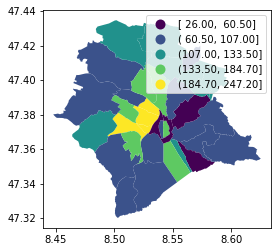

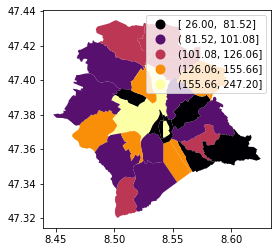

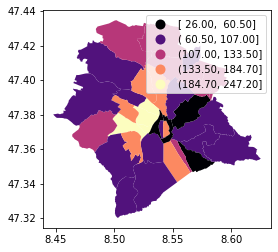

In [39]:
# Plot by StatZonen

stadtquartiere_shapes_joined.plot(column='DichteS', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='DichteS', cmap='inferno', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html
stadtquartiere_shapes_joined.plot(column='DichteS', cmap='magma', scheme='fisherjenks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint Status anpassen!**

Record auf Sharepoint in Bearbeitungsmodus öffnen: **[Link](http://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/EditForm.aspx?ID=831&Source=%2Forga%2Fssz%2Dprodukte%2FLists%2FSASA%5FOutputs)**